In [3]:
# FIX FOR RTX 5080 / CUDA 12 HARDWARE
# This cell patches the environment to ensure TensorFlow finds the GPU correctly
import os
import sys
import ctypes

def preload_nvidia_libs():
    try:
        # Attempt to locate site-packages content
        paths_to_check = []
        if hasattr(sys, 'prefix'):
            paths_to_check.append(os.path.join(sys.prefix, "lib", f"python{sys.version_info.major}.{sys.version_info.minor}", "site-packages", "nvidia"))
        
        nvidia_base = None
        for p in paths_to_check:
            if os.path.exists(p):
                nvidia_base = p
                break
        
        if not nvidia_base:
            print("Could not find nvidia packages to preload. GPU might not be detected.")
            return

        libs_to_load = [
            ("cudnn/lib", "libcudnn.so.9"),
            ("cublas/lib", "libcublas.so.12"),
            ("cublas/lib", "libcublasLt.so.12"),
            ("cufft/lib", "libcufft.so.11"),
            ("curand/lib", "libcurand.so.10"),
            ("cusolver/lib", "libcusolver.so.11"),
            ("cusparse/lib", "libcusparse.so.12"),
            ("nccl/lib", "libnccl.so.2"),
        ]
        
        print(f"Preloading NVIDIA libraries from {nvidia_base}...")
        for subdir, libname in libs_to_load:
            path = os.path.join(nvidia_base, subdir, libname)
            if os.path.exists(path):
                try:
                    ctypes.CDLL(path)
                except Exception as e:
                    print(f"Warning: Failed to load {libname}: {e}")
        print("NVIDIA libraries preloaded.")
    except Exception as e:
        print(f"Error during preload: {e}")

preload_nvidia_libs()


Preloading NVIDIA libraries from /home/fabit/brain-tumor-detection/.venv/lib/python3.12/site-packages/nvidia...
NVIDIA libraries preloaded.


- Data source: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation

# IMPORT LIBRARIES AND DATASETS

In [4]:
# Configuration and paths
import os
from pathlib import Path

# Set base directory (notebooks are in notebooks/, data and models are in parent directory)
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
MODELS_DIR = BASE_DIR / 'models'

# Ensure directories exist
DATA_DIR.mkdir(exist_ok=True)
MODELS_DIR.mkdir(exist_ok=True)

# Configuration constants
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
IMAGE_SIZE = (256, 256)
EPOCHS = 50

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score,RocCurveDisplay, precision_score, f1_score
import random

# Configure matplotlib for better visualization
plt.style.use('default')
%matplotlib inline

In [1]:
# Custom Callback that forces printing to stdout to ensure visibility
from tensorflow.keras.callbacks import Callback

class ForceProgressPrint(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f'\n🚀 Starting Epoch {epoch + 1}...')

    def on_train_batch_end(self, batch, logs=None):
        if batch % 10 == 0:  # Print every 10 batches
            loss = logs.get('loss', 0)
            acc = logs.get('accuracy', 0)
            print(f'   Batch {batch}: Loss = {loss:.4f}, Accuracy = {acc:.4f}')


I0000 00:00:1765235193.855486     639 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1765235193.899048     639 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1765235194.620005     639 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [6]:
# Google Colab code removed - running locally
# Data should be in the 'data' directory relative to the notebook

In [7]:
# Google Colab directory change removed - running locally
# Working directory is already set to the project root


In [8]:
# Load data from data directory
brain_df = pd.read_csv(DATA_DIR / 'route_label.csv', index_col=0)
brain_df.head(10)

,image_path,mask_path,mask
0,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,0
1,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,0
2,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,0
3,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,1
4,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,1
5,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,0
6,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,0
7,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,1
8,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,1
9,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,./data/TCGA_CS_4941_19960909/TCGA_CS_4941_1996...,0


# RESNET50 CLASSIFIER MODEL 

https://arxiv.org/pdf/1512.03385.pdf

In [9]:
# Drop the patient id column
brain_df.shape

(3899, 3)

In [10]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe

brain_df['mask'] = brain_df['mask'].apply(lambda x: str(x))

In [11]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3899 entries, 0 to 3898
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3899 non-null   object
 1   mask_path   3899 non-null   object
 2   mask        3899 non-null   object
dtypes: object(3)
memory usage: 121.8+ KB


In [12]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df, test_size = 0.15,random_state=42)

In [13]:
train.to_csv('train.csv')
test.to_csv('test.csv')

In [14]:

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split = 0.15,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')


In [15]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=str(BASE_DIR),
x_col='image_path',
y_col='mask',
subset="training",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=IMAGE_SIZE
)


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory=str(BASE_DIR),
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=BATCH_SIZE,
shuffle=True,
class_mode="categorical",
target_size=IMAGE_SIZE)

# Create a data generator for test images
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory=str(BASE_DIR),
x_col='image_path',
y_col='mask',
batch_size=BATCH_SIZE,
shuffle=False,
class_mode='categorical',
target_size=IMAGE_SIZE)


Found 2817 validated image filenames belonging to 2 classes.


Found 497 validated image filenames belonging to 2 classes.
Found 585 validated image filenames belonging to 2 classes.


In [16]:
# Get the ResNet50 base model
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

W0000 00:00:1765232678.972359    4691 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765232678.972758    4691 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765232678.973045    4691 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0000 00:00:1765232678.973059    4691 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1765232678.975284    4691 cuda_executor.cc:1840] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not us

In [17]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [19]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,817,218 (98.48 MB)

 Trainable params: 25,764,098 (98.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
# compile the model

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [22]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model2.keras"), verbose=1,save_best_only=True)


In [23]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[ForceProgressPrint(), checkpointer, earlystopping])


🚀 Starting Epoch 1...


I0000 00:00:1765232693.856803    4897 service.cc:153] XLA service 0x79d8740c6430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765232693.856841    4897 service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5080, Compute Capability 12.0a
I0000 00:00:1765232694.221470    4897 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765232696.495727    4897 cuda_dnn.cc:461] Loaded cuDNN version 91700
I0000 00:00:1765232697.606376    5050 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_MatMul_22', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1765232709.734503    5049 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1765232710.779457    5049 subprocess_com

   Batch 0: Loss = 0.8416, Accuracy = 0.5156
10/44 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.5967 - loss: 1.0367   Batch 10: Loss = 0.8202, Accuracy = 0.6648
20/44 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.6442 - loss: 0.8960   Batch 20: Loss = 0.7139, Accuracy = 0.7083
30/44 ━━━━━━━━━━━━━━━━━━━━ 9s 688ms/step - accuracy: 0.6678 - loss: 0.8252    Batch 30: Loss = 0.6376, Accuracy = 0.7272
40/44 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.6862 - loss: 0.7695   Batch 40: Loss = 0.5667, Accuracy = 0.7563
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.6930 - loss: 0.7506
Epoch 1: val_loss improved from None to 12.51945, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model2.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 64s 682ms/step - accuracy: 0.7646 - loss: 0.5544 - val_accuracy: 0.3661 - val_loss: 12.5194


In [25]:
# save the model architecture to json file for future use
checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model3.keras"), verbose=1,save_best_only=True)
model.load_weights(str(MODELS_DIR / "classifier-resnet-model3.keras"))
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[checkpointer, earlystopping])

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8627 - loss: 0.3056
Epoch 1: val_loss improved from None to 0.66587, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model3.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - accuracy: 0.8663 - loss: 0.2970 - val_accuracy: 0.6272 - val_loss: 0.6659
Epoch 2/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.8750 - loss: 0.2938
Epoch 2: val_loss improved from 0.66587 to 0.65768, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model3.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8750 - loss: 0.2938 - val_accuracy: 0.6384 - val_loss: 0.6577
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8465 - loss: 0.3231
Epoch 3: val_loss did not improve from 0.65768
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 278ms/step - accuracy: 0.8511 - loss: 0.3142 - val_accuracy: 0.6339 - val_loss: 0.6640
Epoch 4/100
 1/44 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy

In [26]:

model.load_weights(str(MODELS_DIR / "classifier-resnet-model3.keras"))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model4.keras"), verbose=1,save_best_only=True)

lr_reduce=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-11),
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[ForceProgressPrint(), checkpointer, earlystopping,lr_reduce])


🚀 Starting Epoch 1...
Epoch 1/100


I0000 00:00:1765233283.150377    4897 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_36', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_27', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 24 bytes spill stores, 24 bytes spill loads



   Batch 0: Loss = 0.0996, Accuracy = 0.9844
10/44 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.9388 - loss: 0.1903   Batch 10: Loss = 0.2064, Accuracy = 0.9247
20/44 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.9275 - loss: 0.2127   Batch 20: Loss = 0.2496, Accuracy = 0.9122
30/44 ━━━━━━━━━━━━━━━━━━━━ 7s 529ms/step - accuracy: 0.9228 - loss: 0.2225   Batch 30: Loss = 0.2414, Accuracy = 0.9136
40/44 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9214 - loss: 0.2250   Batch 40: Loss = 0.2308, Accuracy = 0.9211
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9215 - loss: 0.2253
Epoch 1: val_loss improved from None to 34.44895, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model4.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 552ms/step - accuracy: 0.9226 - loss: 0.2273 - val_accuracy: 0.5156 - val_loss: 34.4490 - learning_rate: 0.0010

🚀 Starting Epoch 2...
Epoch 2/100
   Batch 0: Loss = 0.1406, Accuracy = 0.9531
 1/44 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/ste

MINI CHALLENGE #5:
- Change the network architecture by adding more/less dense layers, neurons or dropout.
- print out the model summary and compare the total number of trainable parameters between the original and new model

In [27]:

model.load_weights(str(MODELS_DIR / "classifier-resnet-model4.keras"))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model5.keras"), verbose=1,save_best_only=True)

lr_reduce=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-12),
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[ForceProgressPrint(), checkpointer, earlystopping,lr_reduce])


🚀 Starting Epoch 1...
Epoch 1/100


I0000 00:00:1765233575.056599    4899 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_36', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_27', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 24 bytes spill stores, 24 bytes spill loads



   Batch 0: Loss = 0.0519, Accuracy = 0.9688
10/44 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step - accuracy: 0.9392 - loss: 0.1986   Batch 10: Loss = 0.1929, Accuracy = 0.9418
20/44 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.9411 - loss: 0.1897   Batch 20: Loss = 0.1776, Accuracy = 0.9438
30/44 ━━━━━━━━━━━━━━━━━━━━ 8s 573ms/step - accuracy: 0.9420 - loss: 0.1855   Batch 30: Loss = 0.1822, Accuracy = 0.9443
40/44 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.9424 - loss: 0.1839   Batch 40: Loss = 0.1794, Accuracy = 0.9414
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.9423 - loss: 0.1834
Epoch 1: val_loss improved from None to 16.41238, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model5.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 583ms/step - accuracy: 0.9415 - loss: 0.1790 - val_accuracy: 0.6741 - val_loss: 16.4124 - learning_rate: 0.0010

🚀 Starting Epoch 2...
Epoch 2/100
   Batch 0: Loss = 0.1425, Accuracy = 0.9375
 1/44 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/st

In [28]:
model.load_weights(str(MODELS_DIR / "classifier-resnet-model5.keras"))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model6.keras"), verbose=1,save_best_only=True)

lr_reduce=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-12),
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[ForceProgressPrint(), checkpointer, earlystopping,lr_reduce])


🚀 Starting Epoch 1...
Epoch 1/100


I0000 00:00:1765234164.949326    4896 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_36', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_27', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 24 bytes spill stores, 24 bytes spill loads



   Batch 0: Loss = 0.0180, Accuracy = 1.0000
10/44 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - accuracy: 0.9537 - loss: 0.1464   Batch 10: Loss = 0.1955, Accuracy = 0.9418
20/44 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.9460 - loss: 0.1693   Batch 20: Loss = 0.1864, Accuracy = 0.9405
30/44 ━━━━━━━━━━━━━━━━━━━━ 10s 718ms/step - accuracy: 0.9449 - loss: 0.1711   Batch 30: Loss = 0.1677, Accuracy = 0.9438
40/44 ━━━━━━━━━━━━━━━━━━━━ 2s 628ms/step - accuracy: 0.9452 - loss: 0.1692   Batch 40: Loss = 0.1591, Accuracy = 0.9477
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.9454 - loss: 0.1682
Epoch 1: val_loss improved from None to 0.57928, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model6.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 58s 723ms/step - accuracy: 0.9470 - loss: 0.1585 - val_accuracy: 0.9263 - val_loss: 0.5793 - learning_rate: 0.0010

🚀 Starting Epoch 2...
Epoch 2/100
   Batch 0: Loss = 0.1312, Accuracy = 0.9531
 1/44 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/ste

In [30]:
model=load_model(str(MODELS_DIR / "classifier-resnet-model6.keras"))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model7.keras"), verbose=1,save_best_only=True)

lr_reduce=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-12),
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[ForceProgressPrint(), checkpointer, earlystopping,lr_reduce])


🚀 Starting Epoch 1...
Epoch 1/100


I0000 00:00:1765234432.379322    4897 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_36', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_27', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 24 bytes spill stores, 24 bytes spill loads



   Batch 0: Loss = 0.0602, Accuracy = 0.9844
10/44 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - accuracy: 0.9564 - loss: 0.1692   Batch 10: Loss = 0.2043, Accuracy = 0.9446
20/44 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.9520 - loss: 0.1780   Batch 20: Loss = 0.1731, Accuracy = 0.9472
30/44 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.9491 - loss: 0.1799   Batch 30: Loss = 0.1748, Accuracy = 0.9451
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9483 - loss: 0.1796   Batch 40: Loss = 0.1749, Accuracy = 0.9470
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.9483 - loss: 0.1790
Epoch 1: val_loss improved from None to 1.04625, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model7.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 48s 573ms/step - accuracy: 0.9473 - loss: 0.1745 - val_accuracy: 0.8728 - val_loss: 1.0463 - learning_rate: 0.0010

🚀 Starting Epoch 2...
Epoch 2/100
   Batch 0: Loss = 0.1547, Accuracy = 0.9688
 1/44 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step 

In [32]:
model=load_model(str(MODELS_DIR / "classifier-resnet-model7.keras"))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

checkpointer = ModelCheckpoint(filepath=str(MODELS_DIR / "classifier-resnet-model8.keras"), verbose=1,save_best_only=True)

lr_reduce=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-12),
history = model.fit(train_generator, steps_per_epoch= train_generator.n // BATCH_SIZE, epochs = 100, validation_data= valid_generator, validation_steps= valid_generator.n // BATCH_SIZE, callbacks=[ForceProgressPrint(), checkpointer, earlystopping,lr_reduce])


🚀 Starting Epoch 1...
Epoch 1/100


I0000 00:00:1765234664.836885    4896 subprocess_compilation.cc:348] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_36', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_27', 32 bytes spill stores, 32 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_15', 24 bytes spill stores, 24 bytes spill loads



   Batch 0: Loss = 0.1729, Accuracy = 0.9375
10/44 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - accuracy: 0.9599 - loss: 0.1270   Batch 10: Loss = 0.1892, Accuracy = 0.9517
20/44 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.9519 - loss: 0.1618   Batch 20: Loss = 0.1971, Accuracy = 0.9382
30/44 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.9472 - loss: 0.1733   Batch 30: Loss = 0.1941, Accuracy = 0.9360
40/44 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step - accuracy: 0.9450 - loss: 0.1775   Batch 40: Loss = 0.1867, Accuracy = 0.9399
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9447 - loss: 0.1778
Epoch 1: val_loss improved from None to 0.43370, saving model to /home/fabit/brain-tumor-detection/models/classifier-resnet-model8.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 51s 624ms/step - accuracy: 0.9433 - loss: 0.1768 - val_accuracy: 0.9196 - val_loss: 0.4337 - learning_rate: 0.0010

🚀 Starting Epoch 2...
Epoch 2/100
   Batch 0: Loss = 0.1647, Accuracy = 0.9531
 1/44 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step 

# TRAINED MODEL TESTING

In [33]:
# Load pretrained modeL

model=load_model(str(MODELS_DIR / "classifier-resnet-model8.keras"))


In [34]:
test_predict = model.predict(test_generator, steps = test_generator.n // BATCH_SIZE, verbose =1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step


In [35]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)
predict = predict.astype("object")

In [36]:
# since we have used test generator, it limited the images to len(predict), due to batch size
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [37]:
# Obtain the accuracy of the model

print("accuracy_score: ", accuracy_score(original, predict))
print("f1_score: ", f1_score(original, predict,pos_label="1"))
print("precision_score: ", precision_score(original, predict,pos_label="1"))
print("recall_score: ", recall_score(original, predict,pos_label="1"))

accuracy_score:  0.9722222222222222
f1_score:  0.9572192513368984
precision_score:  0.9521276595744681
recall_score:  0.9623655913978495


In [38]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       390
           1       0.95      0.96      0.96       186

   micro avg       0.97      0.97      0.97       576
   macro avg       0.97      0.97      0.97       576
weighted avg       0.97      0.97      0.97       576



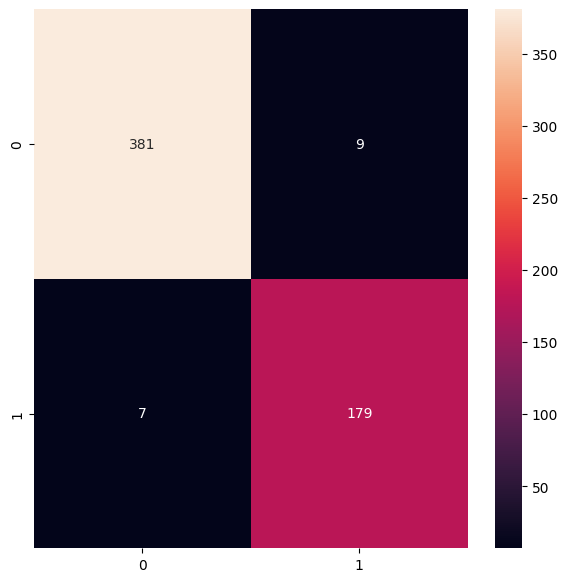

In [39]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True, fmt="d");

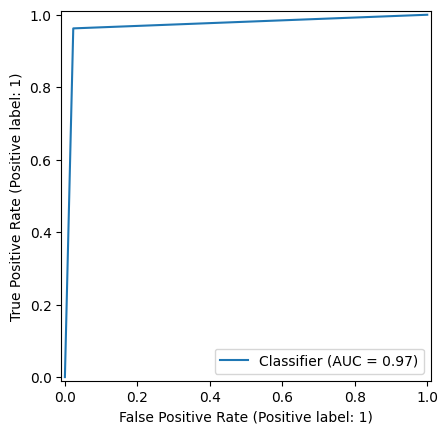

In [40]:
original=original.astype("int")
predict=predict.astype("int")
RocCurveDisplay.from_predictions(original, predict);
